In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch.unitroot import ADF,KPSS
from pmdarima import auto_arima
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import zivot_andrews
import ruptures as rpt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from prophet import Prophet




In [25]:
data=pd.read_excel("EVDS (2).xlsx")

In [26]:

data["Tarih"] = pd.to_datetime(data["Tarih"], format="%Y-%m")

data.asfreq("MS")
data = data.set_index("Tarih")
data.info()
data.head(5)


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 190 entries, 2010-01-01 to 2025-10-01
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   TP KFE TR  190 non-null    float64
dtypes: float64(1)
memory usage: 3.0 KB


,TP KFE TR
Tarih,
2010-01-01,4.57
2010-02-01,4.57
2010-03-01,4.58
2010-04-01,4.63
2010-05-01,4.68


In [27]:


train = data.iloc[:-24]
test  = data.iloc[-24:]









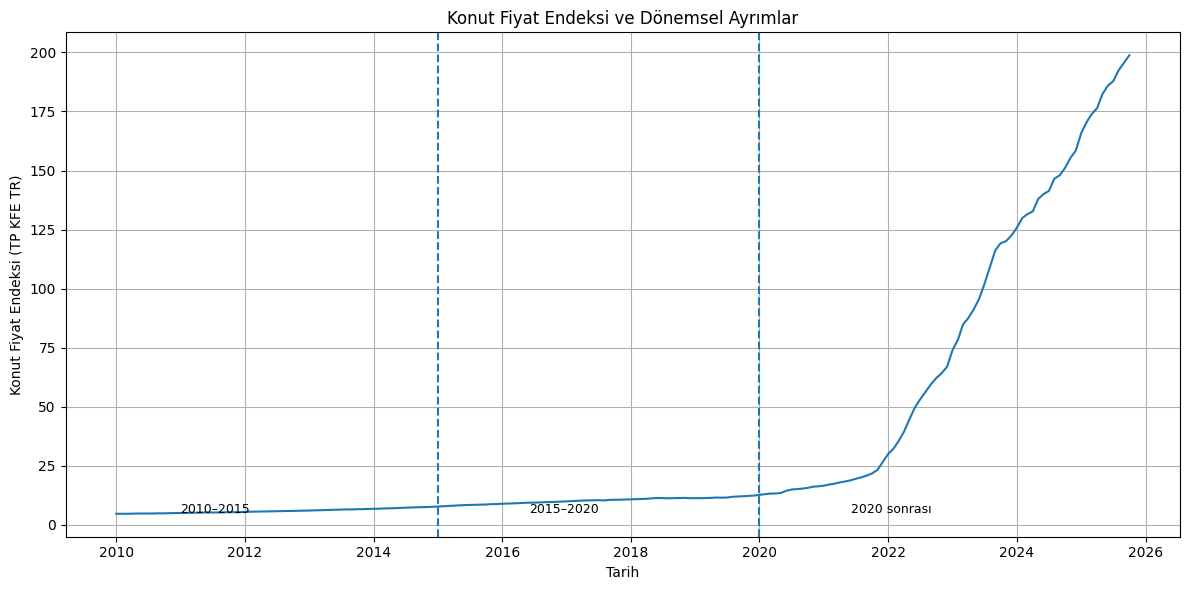

In [28]:
plt.figure(figsize=(12, 6))

plt.plot(data["TP KFE TR"])


plt.axvline(pd.Timestamp("2015-01-01"), linestyle="--")
plt.axvline(pd.Timestamp("2020-01-01"), linestyle="--")

plt.text(pd.Timestamp("2011-01-01"), data["TP KFE TR"].min()*1.1, "2010–2015", fontsize=9)
plt.text(pd.Timestamp("2016-06-01"), data["TP KFE TR"].min()*1.1, "2015–2020", fontsize=9)
plt.text(pd.Timestamp("2021-06-01"), data["TP KFE TR"].min()*1.1, "2020 sonrası", fontsize=9)

plt.title("Konut Fiyat Endeksi ve Dönemsel Ayrımlar")
plt.xlabel("Tarih")
plt.ylabel("Konut Fiyat Endeksi (TP KFE TR)")
plt.grid(True)

plt.tight_layout()
plt.show()


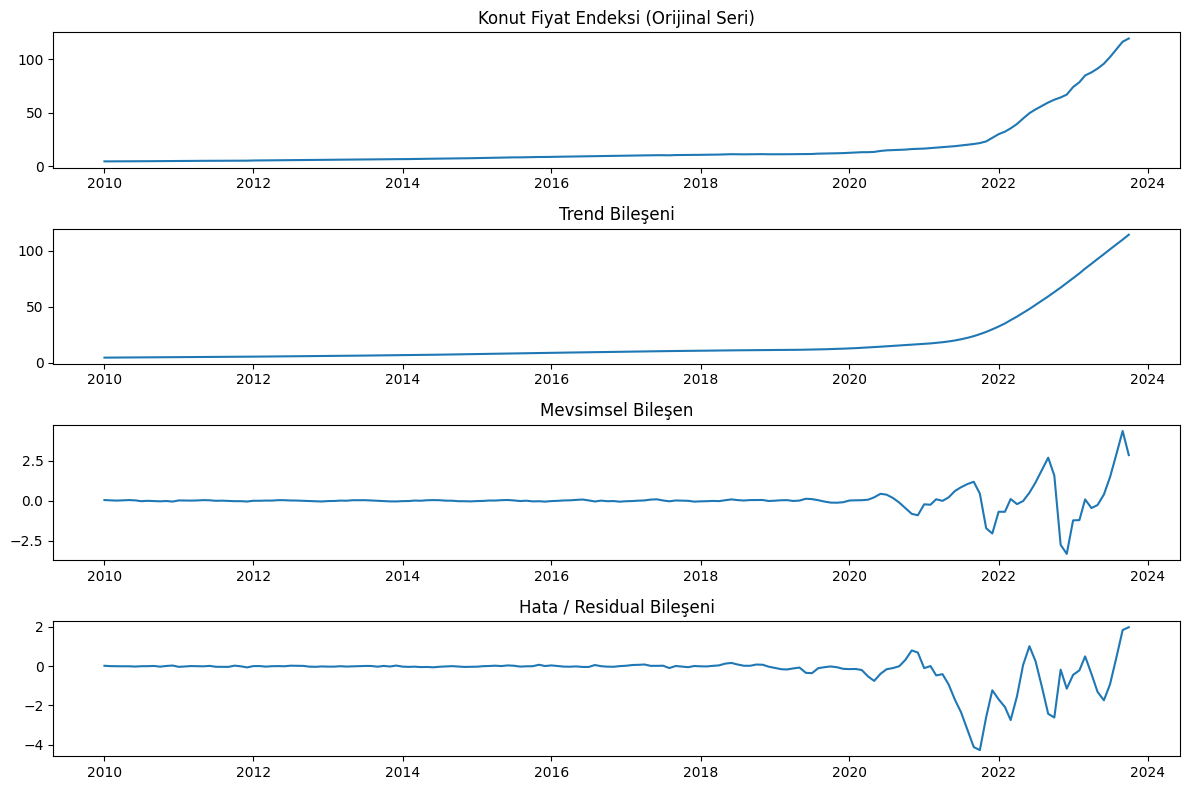

Tarih
2010-01-01      4.57
2010-02-01      4.57
2010-03-01      4.58
2010-04-01      4.63
2010-05-01      4.68
               ...  
2023-06-01     95.66
2023-07-01    101.87
2023-08-01    108.97
2023-09-01    116.18
2023-10-01    119.18
Name: TP KFE TR, Length: 166, dtype: float64

In [29]:



y = train["TP KFE TR"].copy()

stl = STL(y, period=12)
result = stl.fit()

trend = result.trend
seasonal = result.seasonal
residual = result.resid

plt.figure(figsize=(12, 8))

plt.subplot(4, 1, 1)
plt.plot(y)
plt.title("Konut Fiyat Endeksi (Orijinal Seri)")

plt.subplot(4, 1, 2)
plt.plot(trend)
plt.title("Trend Bileşeni")

plt.subplot(4, 1, 3)
plt.plot(seasonal)
plt.title("Mevsimsel Bileşen")

plt.subplot(4, 1, 4)
plt.plot(residual)
plt.title("Hata / Residual Bileşeni")

plt.tight_layout()
plt.show()

y


In [30]:


adf=ADF(train)
kpss=KPSS(train)

print(adf)
print(kpss)

train

   Augmented Dickey-Fuller Results   
Test Statistic                 -0.678
P-value                         0.852
Lags                               12
-------------------------------------

Trend: Constant
Critical Values: -3.47 (1%), -2.88 (5%), -2.58 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
    KPSS Stationarity Test Results   
Test Statistic                  1.035
P-value                         0.002
Lags                                8
-------------------------------------

Trend: Constant
Critical Values: 0.74 (1%), 0.46 (5%), 0.35 (10%)
Null Hypothesis: The process is weakly stationary.
Alternative Hypothesis: The process contains a unit root.


,TP KFE TR
Tarih,
2010-01-01,4.57
2010-02-01,4.57
2010-03-01,4.58
2010-04-01,4.63
2010-05-01,4.68
...,...
2023-06-01,95.66
2023-07-01,101.87
2023-08-01,108.97


In [31]:
za_result = zivot_andrews(y, trim=0.15)  

print("Zivot-Andrews Yapısal Kırılma Testi Sonuçları")
print("---------------------------------------------")
print(f"Test İstatistiği: {za_result[0]}")
print(f"P-Değeri: {za_result[1]}")
print(f"Kritik Değerler: {za_result[2]}")
print(f"Kırılma Noktası (indeks): {za_result[3]}")


break_date = y.index[za_result[3]]
print(f"Kırılma Tarihi: {break_date}")


train

Zivot-Andrews Yapısal Kırılma Testi Sonuçları
---------------------------------------------
Test İstatistiği: -3.8789365457518943
P-Değeri: 0.426934322617759
Kritik Değerler: {'1%': -5.27644, '5%': -4.81067, '10%': -4.56618}
Kırılma Noktası (indeks): 14
Kırılma Tarihi: 2011-03-01 00:00:00


,TP KFE TR
Tarih,
2010-01-01,4.57
2010-02-01,4.57
2010-03-01,4.58
2010-04-01,4.63
2010-05-01,4.68
...,...
2023-06-01,95.66
2023-07-01,101.87
2023-08-01,108.97


Kırılma indeksleri: [65, 125, 145, 190]


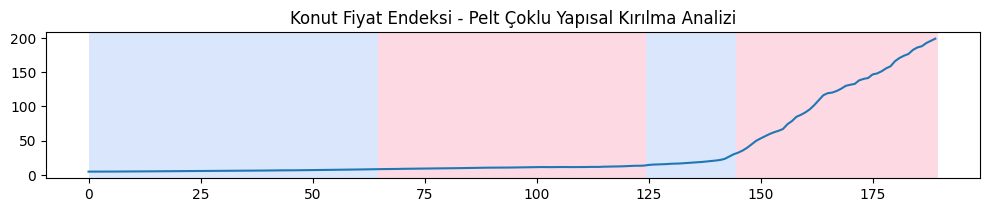

In [32]:

y = data["TP KFE TR"].values  

model = "rbf"   
algo = rpt.Pelt(model=model, min_size=12).fit(y)


breaks = algo.predict(pen=5)

print("Kırılma indeksleri:", breaks)


rpt.display(y, breaks)
plt.title("Konut Fiyat Endeksi - Pelt Çoklu Yapısal Kırılma Analizi")
plt.show()

In [33]:
breaks = [65, 125, 145, 190]  
dates = data.index

for idx in breaks[:-1]:  
    print(idx, "→", dates[idx])  


65 → 2015-06-01 00:00:00
125 → 2020-06-01 00:00:00
145 → 2022-02-01 00:00:00


“Ruptures algoritması seride üç kırılma noktası tespit etmiştir: yaklaşık 2015, 2020 ve 2022 dönemleri. Algoritmanın çıkardığı son değer (190) serinin bitişini temsil ettiği için kırılma olarak kabul edilmemektedir.

Grafiksel olarak seri iki ana döneme ayrılmaktadır:
(1) 2010–2020 arasında düşük eğimli, yavaş artan trend;
(2) 2020 sonrası pandemi etkisiyle hızlanan, dik eğimli trend.

2022 civarında görülen ikinci kırılma, pandemi sonrası hızlanmanın içinde gerçekleşen trend değişikliğini yansıtmaktadır, ancak 2024 civarında yeni bir kırılma bulunmamaktadır.”

In [34]:
model=auto_arima(train,trace=False,seasonal=False)
print(model)


c:\Users\Administrator\OneDrive\Desktop\KFE\ts_env\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Administrator\OneDrive\Desktop\KFE\ts_env\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Administrator\OneDrive\Desktop\KFE\ts_env\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Administrator\OneDrive\Desktop\KFE\ts_env\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Administrator\OneDrive\Desktop\KFE\ts_env\lib\site-packages\sklearn\utils\deprecation.py:132: F

 ARIMA(2,2,4)(0,0,0)[0]          


In [35]:
print(model.summary())


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  166
Model:               SARIMAX(2, 2, 4)   Log Likelihood                -138.827
Date:                Fri, 26 Dec 2025   AIC                            291.653
Time:                        19:13:36   BIC                            313.352
Sample:                    01-01-2010   HQIC                           300.462
                         - 10-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5812      0.114      5.100      0.000       0.358       0.804
ar.L2         -0.4572      0.108     -4.228      0.000      -0.669      -0.245
ma.L1         -0.9019      0.115     -7.868      0.0

In [36]:
print("k_exog:", model.arima_res_.model.k_exog)


k_exog: 0


In [37]:

hata=model.resid()
q=acorr_ljungbox(hata)
print(q)

     lb_stat  lb_pvalue
1   4.123744   0.042285
2   4.163042   0.124740
3   4.197585   0.240904
4   4.244873   0.373879
5   4.331836   0.502693
6   4.501376   0.609156
7   4.760747   0.689134
8   5.361428   0.718339
9   9.841240   0.363490
10  9.940761   0.445706


“Ljung–Box testi sonuçlarına göre artıkların büyük çoğunlukla otokorelasyon içermediği görülmektedir. Sadece birinci gecikmede %5 anlamlılık düzeyinde zayıf bir otokorelasyon sinyali tespit edilmiştir. Ancak daha yüksek gecikmelerde bu durum ortadan kalkmakta olup, model artıklarının genel olarak white noise varsayımını büyük ölçüde sağladığı söylenebilir.”

In [38]:
predicted,ci=model.predict(24,return_conf_int=True)

c:\Users\Administrator\OneDrive\Desktop\KFE\ts_env\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Administrator\OneDrive\Desktop\KFE\ts_env\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


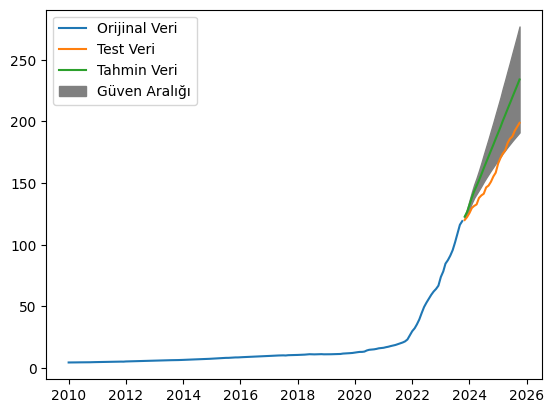

In [39]:
plt.plot(train,label="Orijinal Veri")
plt.plot(test,label="Test Veri")
plt.plot(predicted,label="Tahmin Veri")
plt.fill_between(predicted.index,ci[:,0],ci[:,1],color="gray",label="Güven Aralığı")
plt.legend(loc="upper left")

“Kurulan ARIMA modeli ile elde edilen tahmin sonuçları incelendiğinde, modelin test dönemindeki genel artış trendini başarılı bir şekilde yakaladığı görülmektedir. Gerçekleşen değerlerin büyük ölçüde tahmin güven aralıkları içerisinde yer alması, modelin öngörü performansının tatmin edici olduğunu göstermektedir. Tahmin ufku ilerledikçe güven aralıklarının genişlemesi ise artan belirsizliğin doğal bir sonucudur.”

In [40]:

y_test = test["TP KFE TR"]
y_pred = predicted.loc[y_test.index]

# MSE
mse = mean_squared_error(y_test, y_pred)

# RMSE
rmse = np.sqrt(mse)

# MAE
mae = mean_absolute_error(y_test, y_pred)

# MAPE 
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print(f"MSE  : {mse:.3f}")
print(f"RMSE : {rmse:.3f}")
print(f"MAE  : {mae:.3f}")
print(f"MAPE : {mape:.2f}%")


MSE  : 550.762
RMSE : 23.468
MAE  : 21.552
MAPE : 13.15%


In [41]:

prophet_df = data.reset_index().rename(columns={"Tarih": "ds", "TP KFE TR": "y"})
prophet_df.head(3)

ptrain=prophet_df.iloc[:-24]
ptest=prophet_df.iloc[-24:]



In [42]:
changepoints = pd.to_datetime([
    "2015-06-01",
    "2020-06-01",
    "2022-02-01"
])


pmodel = Prophet(
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=False,
    changepoints=changepoints,
    changepoint_prior_scale=0.1  
)

pmodel.fit(ptrain)
forecast = pmodel.predict(ptest)

forecast.head(2)

train_forecast = pmodel.predict(ptrain)
hata = ptrain["y"].values - train_forecast["yhat"].values
q=acorr_ljungbox(hata)
print(q)






19:13:37 - cmdstanpy - INFO - Chain [1] start processing
19:13:37 - cmdstanpy - INFO - Chain [1] done processing


       lb_stat     lb_pvalue
1   124.249054  7.430646e-29
2   185.980537  4.119452e-41
3   206.706653  1.499422e-44
4   211.907809  1.032763e-44
5   212.149301  7.133006e-44
6   214.201177  1.792540e-43
7   229.086671  7.759050e-46
8   268.977521  1.621449e-53
9   334.325793  1.338306e-66
10  407.542398  2.334638e-81


“Prophet modelinden elde edilen artıklar üzerinde yapılan Ljung–Box testi, artıkların anlamlı düzeyde otokorelasyon içerdiğini göstermektedir. Ancak Prophet modeli deterministik bir trend yaklaşımına dayandığından, tüm stokastik bağımlılığı açıklaması beklenmemektedir. Bu nedenle söz konusu sonuç, modelin tahmin performansını geçersiz kılmamaktadır.”

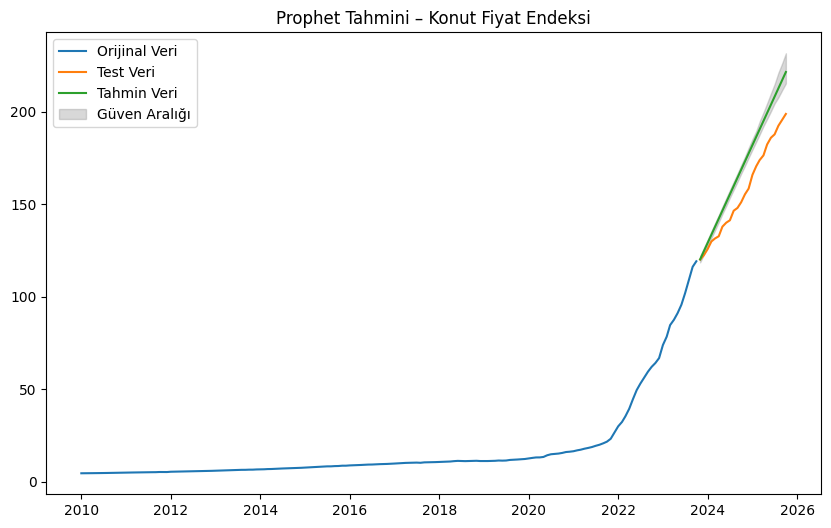

In [43]:
plt.figure(figsize=(10,6))
plt.plot(ptrain["ds"], ptrain["y"], label="Orijinal Veri")
plt.plot(ptest["ds"], ptest["y"], label="Test Veri")
plt.plot(
    forecast["ds"],
    forecast["yhat"],
    label="Tahmin Veri"
)
plt.fill_between(
    forecast["ds"],
    forecast["yhat_lower"],
    forecast["yhat_upper"],
    color="gray",
    alpha=0.3,
    label="Güven Aralığı"
)

plt.legend(loc="upper left")
plt.title("Prophet Tahmini – Konut Fiyat Endeksi")
plt.show()

In [44]:
# MSE
mse = mean_squared_error(ptest["y"],forecast["yhat"] )

# RMSE
rmse = np.sqrt(mse)

# MAE
mae = mean_absolute_error(ptest["y"], forecast["yhat"])


ptest.index = range(len(ptest))

# MAPE 

mape = np.mean(np.abs((ptest["y"].to_numpy() - forecast["yhat"].to_numpy()) / ptest["y"].to_numpy())) * 100

print(f"MSE  : {mse:.3f}")
print(f"RMSE : {rmse:.3f}")
print(f"MAE  : {mae:.3f}")
print(f"MAPE : {mape:.2f}%")

MSE  : 230.251
RMSE : 15.174
MAE  : 13.731
MAPE : 8.35%


19:13:37 - cmdstanpy - INFO - Chain [1] start processing
19:13:37 - cmdstanpy - INFO - Chain [1] done processing


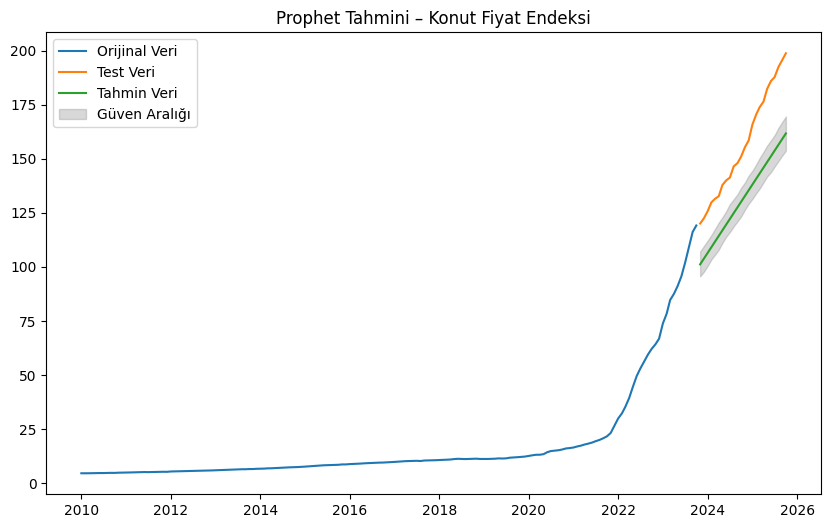

In [45]:

pmodel_auto = Prophet(
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=False,
    changepoint_prior_scale=0.1,   
    n_changepoints=25              
)

pmodel_auto.fit(ptrain)
forecast = pmodel_auto.predict(ptest)

plt.figure(figsize=(10,6))
plt.plot(ptrain["ds"], ptrain["y"], label="Orijinal Veri")
plt.plot(ptest["ds"], ptest["y"], label="Test Veri")
plt.plot(
    forecast["ds"],
    forecast["yhat"],
    label="Tahmin Veri"
)
plt.fill_between(
    forecast["ds"],
    forecast["yhat_lower"],
    forecast["yhat_upper"],
    color="gray",
    alpha=0.3,
    label="Güven Aralığı"
)

plt.legend(loc="upper left")
plt.title("Prophet Tahmini – Konut Fiyat Endeksi")
plt.show()

In [46]:
# MSE
mse = mean_squared_error(ptest["y"],forecast["yhat"] )

# RMSE
rmse = np.sqrt(mse)

# MAE
mae = mean_absolute_error(ptest["y"], forecast["yhat"])


ptest.index = range(len(ptest))

# MAPE 
mape = np.mean(np.abs((ptest["y"].to_numpy() - forecast["yhat"].to_numpy()) / ptest["y"].to_numpy())) * 100

print(f"MSE  : {mse:.3f}")
print(f"RMSE : {rmse:.3f}")
print(f"MAE  : {mae:.3f}")
print(f"MAPE : {mape:.2f}%")

MSE  : 702.261
RMSE : 26.500
MAE  : 25.648
MAPE : 16.10%


## Model Comparison Summary

This study compares the short-term forecasting performance of **ARIMA(2,2,4)** and **Prophet** models on the Turkish House Price Index using the same train–test split.

Graphical analysis shows that while the ARIMA model captures the overall upward trend, it struggles to represent the sharp increase observed after 2020. In contrast, the Prophet model, supported by manually specified changepoints, more effectively captures trend breaks and rapid growth periods.

Quantitative evaluation based on **RMSE, MAE, and MAPE** indicates that the Prophet model outperforms ARIMA across all error metrics, with MAPE falling below 10%, suggesting higher short-term forecast accuracy.

Residual diagnostics reveal that ARIMA residuals are close to white noise, whereas Prophet residuals exhibit autocorrelation. However, given Prophet’s deterministic trend-based modeling approach, this does not undermine its superior predictive performance.

Overall, the results suggest that **Prophet is better suited for short-term forecasting in the presence of structural breaks and regime changes**, while **ARIMA remains a strong alternative for more stable, stochastic time series**.
